<a href="https://colab.research.google.com/github/bth0114/AIFFEL_DLThon_DKTC_online13/blob/main/notebooks/jiwoong/baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install konlpy
!pip install wandb

## 모듈 불러오기 및 파일 경로 지정

In [2]:
import os
import re
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from konlpy.tag import Okt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.metrics import F1Score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout, Input

import wandb
from wandb.integration.keras.callbacks import WandbMetricsLogger
wandb.login()

wandb: Currently logged in as: 00_jw (jiwoong-team) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [3]:
%cd /content/drive/MyDrive/Colab Notebooks/Aiffel/AIFFEL_DLThon_DKTC_online13
current_dir = os.getcwd()
csv_dir = os.path.join(current_dir, 'data', 'raw_csv')
train_csv_path = os.path.join(csv_dir, 'merged_train.csv')

/content/drive/MyDrive/Colab Notebooks/Aiffel/AIFFEL_DLThon_DKTC_online13


## 데이터 전처리
- 구두점 제거
- 명사, 동사, 형용사, 부사, 숫자를 기준으로 토큰화
- 최대 길이를 기준으로 패딩

In [4]:
INPUT_MAX_LENGTH = 350  # 입력 시퀀스 최대 길이
NUM_WORDS = 7000 # 토큰화에 사용할 단어 갯수
EMBEDDING_DIM = 64  # 임베딩 차원

In [5]:
df = pd.read_csv(train_csv_path)
ordered_columns = ['협박 대화', '갈취 대화', '직장 내 괴롭힘 대화', '기타 괴롭힘 대화', '일반 대화'] # kaggle에 명시된 순서로 재배치

conversations = df['conversation'].to_list() # input
labels = pd.get_dummies(df['class'])
labels = labels[ordered_columns].to_numpy() # target

In [6]:
# 훈련셋,검증셋 분리
X_train_raw, X_val_raw, y_train, y_val = train_test_split(conversations, labels, test_size=0.2, stratify=labels, random_state=42)

In [7]:
# 구두점을 제거하는 함수
def remove_punctuation(texts):
    result = []
    for text in texts:
        # ?! 제외한 모든 특수문자 제거
        text = re.sub(r'[^\w\s?!]', '', text.replace('\n', ' '))
        result.append(text)
    return result

# 명사, 동사, 형용사, 부사, 숫자를 기준으로 토큰화해주는 함수
def pos_tagging(texts):
    okt = Okt()

    result = []
    for text in texts:
        filtered_words = [word for word, pos in okt.pos(text) if pos in [
            'Noun', 'Verb', 'Adjective', 'Adverb',  # 기본 품사
            'Number'                                # 금전 관련 숫자 정보
        ]]
        result.append(filtered_words)  # 각 문장별로 필터링된 단어들을 리스트로 저장

    return result

# 토크나이저 생성 함수
def create_tokenizer(texts, num_words=None): # num_words = 인코딩 시 사용할 단어 개수
    tokenizer = Tokenizer(num_words=num_words, oov_token="<OOV>")
    tokenizer.fit_on_texts(texts) # 어휘사전 정의

    return tokenizer

# 모든 전처리 함수. 구두점 제거, 품사기준 토큰화, 정수 인코딩, 패딩
def preprocessing(texts, tokenizer, padded_max_len):
  removed_punctuation_texts = remove_punctuation(texts)
  pos_tagged_texts = pos_tagging(removed_punctuation_texts)
  sequences = tokenizer.texts_to_sequences(pos_tagged_texts)
  padded_sequences = pad_sequences(sequences, maxlen=padded_max_len)

  return padded_sequences

In [8]:
# 토크나이저 생성
tokenizer = create_tokenizer(conversations, NUM_WORDS)
print("생성된 어휘 수:", len(tokenizer.word_index))

생성된 어휘 수: 55065


In [9]:
# 전처리 수행
X_train = preprocessing(X_train_raw, tokenizer, INPUT_MAX_LENGTH)
X_val = preprocessing(X_val_raw, tokenizer, INPUT_MAX_LENGTH)

## 모델 훈련
- 1개의 양방향 LSTM과 드롭아웃 층으로 구성
- F1score를 기준으로 조기종료 수행
- 데이터 셋이 적어 여러번 반복 훈련하여 평균을 내면 더욱 정확한 베이스 모델을 구축할 수 있지만 시간과 한정된 자원 상 한 번의 학습만 진행
- 실험결과는 W&B에 기록

In [10]:
def build_model():
  vocab_size = NUM_WORDS + 1  # 패딩

  inputs = Input(shape=(INPUT_MAX_LENGTH,))
  embedding = Embedding(input_dim=vocab_size, output_dim=EMBEDDING_DIM)(inputs)
  lstm = Bidirectional(LSTM(64))(embedding)
  dropout = Dropout(0.5)(lstm)
  outputs = Dense(5, activation='softmax')(dropout)
  model = Model(inputs=inputs, outputs=outputs)

  return model

model = build_model()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 350)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 350, 64)        │       448,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 514,757 (1.96 MB)

 Trainable params: 514,757 (1.96 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
model = build_model()

# F1Score 평가 지표
f1 = F1Score(average='micro', name='f1')  # micro f1: 전체 클래스 f1score 평균

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', f1])

es_callback = EarlyStopping(
    monitor='val_f1',
    patience=3,
    restore_best_weights=True,
    mode='max'
)

mc_callback = ModelCheckpoint(
  f'./notebooks/jiwoong/models/baseline.keras',
  monitor="val_f1",
  save_best_only=True,
  mode="max"
)

# W&B 프로젝트 초기화
run = wandb.init(
    # Set the wandb entity where your project will be logged (generally your team name).
    entity="jiwoong-team",
    # Set the wandb project where this run will be logged.
    project="DLThon-DKTC",
    # Track hyperparameters and run metadata.
    name=f"baseline_BiLSTM", # 실험 이름
    notes="LLM으로 생성한 일반 대화 데이터를 사용한 기준선 실험", # 실험에 대한 간단한 설명
    config={ # 세부 구성 내용
        "experiment_name": "baseline",
        "general_conversation_type": "LLM에서 생성한 대화 데이터", # 일반 데이터 타입
        "architecture": "BiLSTM(64)",
    },
)

history = model.fit(
    X_train, y_train,
    epochs=40,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[es_callback, mc_callback, WandbMetricsLogger()] # WandbMetricsLogger를 콜백으로 넘겨주기만 하면 알아서 epoch별 metric을 기록
)

# 최적의 모델로 검증세트 예측
y_pred = model.predict(X_val)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_val, axis=1)

# wandb Table 생성
report = classification_report(y_true_labels, y_pred_labels, target_names=ordered_columns, output_dict=True)
columns = ["class", "precision", "recall", "f1-score", "support"]
data = []

for label, metrics in report.items():
    if isinstance(metrics, dict):  # dict일 때만 values 가져오기
        row = [label] + [metrics.get(col, None) for col in columns[1:]]
        data.append(row)

table = wandb.Table(columns=columns, data=data)

# wandb에 훈련 결과 기록
wandb.log({
    "classification_report_table": table,
    "macro_f1": report["macro avg"]["f1-score"],
    "accuracy": report["accuracy"],
    "threat_f1": report["협박 대화"]["f1-score"],
    "extortion_f1": report["갈취 대화"]["f1-score"],
    "workplace_bullying_f1": report["직장 내 괴롭힘 대화"]["f1-score"],
    "other bullying": report["기타 괴롭힘 대화"]["f1-score"],
    "general_conversation_f1": report["일반 대화"]["f1-score"],
})

# 실험 종료
run.finish()

Epoch 1/40
116/116 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - accuracy: 0.3006 - f1: 0.3006 - loss: 1.5425 - val_accuracy: 0.6045 - val_f1: 0.6045 - val_loss: 0.9148
Epoch 2/40
116/116 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.6694 - f1: 0.6694 - loss: 0.8027 - val_accuracy: 0.7619 - val_f1: 0.7619 - val_loss: 0.6264
Epoch 3/40
116/116 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.8069 - f1: 0.8069 - loss: 0.5343 - val_accuracy: 0.7586 - val_f1: 0.7586 - val_loss: 0.6238
Epoch 4/40
116/116 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.8682 - f1: 0.8682 - loss: 0.4234 - val_accuracy: 0.8351 - val_f1: 0.8351 - val_loss: 0.4931
Epoch 5/40
116/116 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.9224 - f1: 0.9224 - loss: 0.2723 - val_accuracy: 0.8211 - val_f1: 0.8211 - val_loss: 0.5013
Epoch 6/40
116/116 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.9185 - f1: 0.9185 - loss: 0.2939 - val_accuracy: 0.8319 - val_f1: 0.8319 - val_loss: 0.5221
Epoch 7/40
116/116 ━━━━━━━━━━━━━━━━━━━━ 3s 26m

accuracy,▁
epoch/accuracy,▁▅▆▇▇▇███████
epoch/epoch,▁▂▂▃▃▄▅▅▆▆▇▇█
epoch/f1,▁▅▆▇▇▇███████
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▅▄▃▂▂▂▁▁▁▁▁▁
epoch/val_accuracy,▁▅▅▇▇▇▇▇█████
epoch/val_f1,▁▅▅▇▇▇▇▇█████
epoch/val_loss,█▃▃▁▁▂▁▂▁▂▃▃▂
extortion_f1,▁
general_conversation_f1,▁


## 결과 분석

In [12]:
y_pred = model.predict(X_val)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_val, axis=1)

print(confusion_matrix(y_true_labels, y_pred_labels))
print(classification_report(y_true_labels, y_pred_labels, target_names=ordered_columns))

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
[[139  18   6  16   0]
 [ 13 164   6  12   0]
 [  4   2 179   8   1]
 [ 12  13  13 164   0]
 [  0   3   2   1 152]]
              precision    recall  f1-score   support

       협박 대화       0.83      0.78      0.80       179
       갈취 대화       0.82      0.84      0.83       195
 직장 내 괴롭힘 대화       0.87      0.92      0.90       194
   기타 괴롭힘 대화       0.82      0.81      0.81       202
       일반 대화       0.99      0.96      0.98       158

    accuracy                           0.86       928
   macro avg       0.87      0.86      0.86       928
weighted avg       0.86      0.86      0.86       928



+ 데이터 EDA 때 예상한 대로 일반대화에 많이 과적합되었으며 직장 내 괴롭힘 대화는 점수가 높음
+ 나머지 세 카테고리에 대해서는 아쉬운 성능

## submission

In [13]:
test_csv_path = os.path.join(csv_dir, 'test.csv')

df_test = pd.read_csv(test_csv_path)
conversations_test = df_test['text'].to_list()

X_text = preprocessing(conversations_test, tokenizer, INPUT_MAX_LENGTH)

In [14]:
# 모델 예측 (Softmax를 사용하여 각 클래스에 대한 확률 계산)
predictions = model.predict(X_text)

# 예측 결과를 클래스 인덱스로 변환
predicted_classes = predictions.argmax(axis=1)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


In [15]:
# id와 예측된 클래스 저장
submission_df = pd.DataFrame({
    'idx': df_test['idx'],
    'class': predicted_classes
})

display(submission_df)

# submission.csv로 저장
submission_df.to_csv('/content/submission.csv', index=False)

,idx,class
0,t_000,1
1,t_001,2
2,t_002,2
3,t_003,3
4,t_004,3
...,...,...
495,t_495,2
496,t_496,0
497,t_497,1
498,t_498,1


## 제출 결과

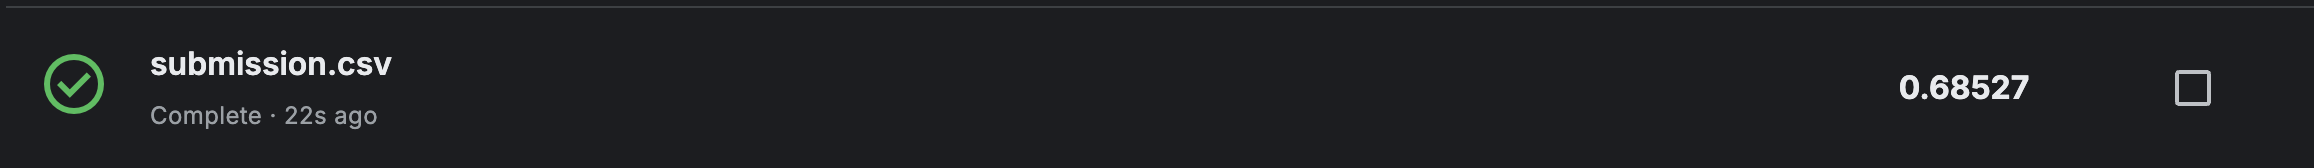